In [2]:
import sys
sys.path.append('./src/')

import numpy as np
import pandas as pd

from src.benchmarks import Naive2
from src.utils_data import M4_parser

In [3]:
X_train_df, y_train_df, X_test_df, y_test_df = M4_parser('Monthly', 10)

Successfully downloaded M4-info.csv 4335598 bytes.
Successfully downloaded Train/Daily-train.csv 95765153 bytes.
Successfully downloaded Train/Hourly-train.csv 2347115 bytes.
Successfully downloaded Train/Monthly-train.csv 91655432 bytes.
Successfully downloaded Train/Quarterly-train.csv 38788547 bytes.
Successfully downloaded Train/Weekly-train.csv 4015067 bytes.
Successfully downloaded Train/Yearly-train.csv 25355736 bytes.
Successfully downloaded Test/Daily-test.csv 576459 bytes.
Successfully downloaded Test/Hourly-test.csv 132820 bytes.
Successfully downloaded Test/Monthly-test.csv 7942698 bytes.
Successfully downloaded Test/Quarterly-test.csv 1971754 bytes.
Successfully downloaded Test/Weekly-test.csv 44247 bytes.
Successfully downloaded Test/Yearly-test.csv 1486434 bytes.




In [28]:
# uid_train_df = y_train_df[y_train_df.unique_id=='M1'].copy()
# uid_train_df['split'] = 'train'
# uid_test_df = y_test_df[y_test_df.unique_id=='M1'].copy()
# uid_test_df['split'] = 'test'
# uid_df = uid_train_df.append(uid_test_df, sort=False)
y_train_df['split'] = 'train'
y_test_df['split'] = 'test'
y_df = y_train_df.append(y_test_df, sort=False)
y_df = y_df.sort_values(by=['unique_id', 'ds'])

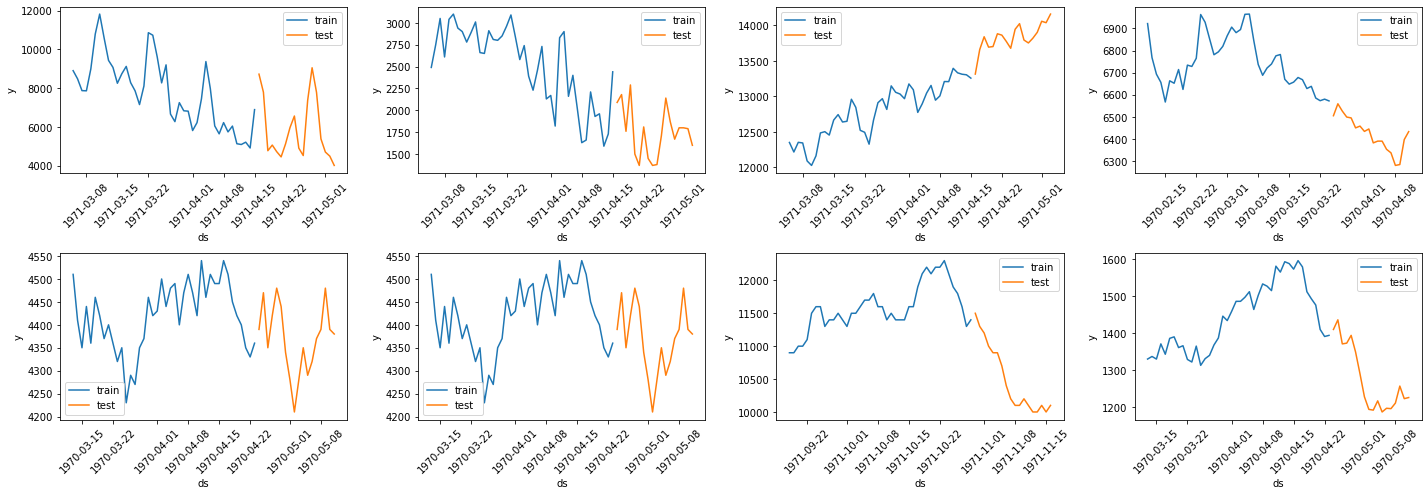

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_single_serie(uid_df, ax):
    """
    uid_df: pandas df
    panel with columns unique_id, ds, y, split
    y_hat_df: pandas df
    panel with columns unique_id, ds, y_hat
    """
    # plot last 60 observations
    sns.lineplot(x='ds', y='y', 
                 hue='split', data=uid_df[-60:], ax=ax)
    
    # rotate x axis
    ax.tick_params(axis='x', rotation=45)
    
    # remove legend title
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:])
    
    #sns.lineplot(x='ds', y='y', data=y_df, color='#FA6F94', label='Actual Data')
    #sns.lineplot(x='ds', y='y', data=y_hat_df, color='#51DBE6', label='Forecast Data', )
    #sns.set_style("dark")
    #plt.xlabel("Date Stamp", fontsize=14, color='#A2A2A2')
    #plt.ylabel("Value", fontsize=14, color='#A2A2A2')
    
def plot_grid_series(y_df, uids):
    assert len(uids)==8
    
    fig, axs = plt.subplots(2, 4, figsize=(20, 7))
    plt.subplots_adjust(wspace=0.35)
    plt.subplots_adjust(hspace=0.4)
    plt.xticks(rotation=45)

    for i, uid in enumerate(uids):
        # single plot parameters
        uid_df = y_df[y_df.unique_id==uid]
        row = int(np.round(i/8 + 0.001))
        col = i % 4
        
        plot_single_serie(uid_df, ax=axs[row, col])
    
    fig.tight_layout()
    plt.show()
    plot_file = "./results/grid_series.png"
    plt.savefig(plot_file, bbox_inches = "tight", dpi=300)
    plt.close()
        
uids = ['M1', 'M2', 'M3', 'M4',
        'M5', 'M5', 'M6', 'M8']
plot_grid_series(y_df, uids)